# Geographic Distribution of [SNAP](http://www.fns.usda.gov/snap/supplemental-nutrition-assistance-program-snap) Activity

This script is a feeder script for **QC_data**, a Notebook housed on the IRS side.  I am writing it here because I don't have the spatial environment set up on the IRS box at this time.  Essentially, we are taking summary data about SNAP participation and benefits, written from **QC_data**, and mapping it.  We will be creating crude maps with [GeoPandas](http://geopandas.org/), but if the need arises at a later date, we can always create better looking maps with [matplotlib](http://matplotlib.org/).

This script may also serve as an illustrative example of capturing spatial distributions in the [Python](https://www.python.org/) environment.  If the reader is new to the [IPython Notebook](http://ipython.org/notebook.html) development environment, note that all hypertext is live given an internet connection.  The libraries used in this example are as follows:

+ **[numpy](http://www.numpy.org/)** is used to perform array operations and serves as the foundation for the **[pandas](http://pandas.pydata.org/)** library (along with many others).  It is noticeably inspired by [fortran](http://www.fortran90.org/), and thus has a very similar feel (albeit coupled with awesome high-level functionality).
+ **[pandas](http://pandas.pydata.org/)** is library with many useful functions for dealing with tabular data.  The **[`Series`](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#series)** and **[`DataFrame`](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe)** objects that have been imported are of particular use.  (Importing them explicitly just alleviates the need to reference the library with every use.)
+ **[GeoPandas](http://geopandas.org/)** was designed to bring **[pandas](http://pandas.pydata.org/)** functionality to spatial data.  In a nutshell, it captures all fields from the [dbf](http://en.wikipedia.org/wiki/DBASE) component of the shapefile in a **[`DataFrame`](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe)**.  The spatial references for each record are captured as [Shapely](http://toblerity.org/shapely/manual.html) objects in an additional field.  [Shapely](http://toblerity.org/shapely/manual.html) objects are just "simple" polygons.  No, you don't have to know all the nuances of such objects to make use of them for simple tasks.  

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import geopandas as gp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Reading in libraries *"as* **`x`**" simply allows us to refer to the library without having to type the entire name.

## Data Input

The relevant [shapefile](http://en.wikipedia.org/wiki/Shapefile) (US States) and the actual data reside in separate locations.  Notice how we read in the shapefile and the [csv](http://en.wikipedia.org/wiki/Comma-separated_values) dataset in analogous ways.  Furthermore, I am setting the [index](http://pandas.pydata.org/pandas-docs/stable/indexing.html) of the state shapefile during the read in.

In [2]:
#Define data locations
shp_dir='C:/Users/marvinw/spatial_data/'
data_dir='O:/Analyst/Marvin/SNAP/'

#Read in data
states=gp.GeoDataFrame.from_file(shp_dir+'tl_2013_us_state.shp').set_index('STATEFP').sort_index()
snap=pd.read_csv(data_dir+'SNAP_st_summ.csv')

We can quickly view the first few rows of the data.  First, the shapefile...

In [3]:
states.head()

ALAND        AWATER DIVISION FUNCSTAT GEOID     INTPTLAT  \
STATEFP                                                                    
01       1.311724e+11  4.594920e+09        6        A    01  +32.7396323   
02       1.477849e+12  2.454879e+11        9        A    02  +63.3461909   
04       2.942050e+11  1.027846e+09        8        A    04  +34.2039355   
05       1.347730e+11  2.958816e+09        7        A    05  +34.8955256   
06       4.034827e+11  2.048430e+10        9        A    06  +37.1551773   

             INTPTLON LSAD  MTFCC        NAME REGION   STATENS STUSPS  \
STATEFP                                                                 
01       -086.8434593   00  G4000     Alabama      3  01779775     AL   
02       -152.8370690   00  G4000      Alaska      4  01785533     AK   
04       -111.6063565   00  G4000     Arizona      4  01779777     AZ   
05       -092.4446262   00  G4000    Arkansas      3  00068085     AR   
06       -119.5434183   00  G4000  California      4  01779778     CA   

                                                  geometry  
STATEFP                                                     
01       POLYGON ((-88.406201 30.589708, -88.4063429999...  
02       (POLYGON ((-135.722551 59.729629, -135.633077 ...  
04       POLYGON ((-110.75069 37.003197, -110.737828 37...  
05       POLYGON ((-94.46025 34.538384, -94.460264 34.5...  
06       (POLYGON ((-123.792812 39.102313, -123.793856 ...

...and then the data we actually want to map.

In [4]:
#Capture average benefits per participant
snap['AVG_BEN']=snap['WBEN']/snap['WPART']

snap.head()

Unnamed: 0  STATE          FYWGT           WPART          WBEN  year  \
0           0      1  214595.157644   532983.878161  4.747416e+07  2006   
1           1      2   20645.380109    54778.206514  6.920696e+06  2006   
2           2      4  209523.733711   515211.238976  4.931475e+07  2006   
3           3      5  154660.905698   374223.844044  3.249277e+07  2006   
4           4      6  791521.606080  1972619.602490  1.944563e+08  2006   

      AVG_BEN  
0   89.072407  
1  126.340316  
2   95.717539  
3   86.827099  
4   98.577698

## Spatial Integration

Before plotting, we need to join these sets together.  GeoPandas was built on the **pandas** library, specifically to leverage pandas' methods.  Consequently, joining the shapefile to the data is just as easy as joining two **`DataFrames`** (DFs) together.  We would like to join on the [FIPS](http://en.wikipedia.org/wiki/Federal_Information_Processing_Standards) code, so we need to standardize them, and restrict ourselves to the relevant jurisdictions.  This means executing the following:

1. Standardize the state FIPS codes.  In the shapefile, they are [strings](http://en.wikipedia.org/wiki/String_(computer_science)) with leading zeroes for single digits, while the SNAP data represents them as [integers](http://en.wikipedia.org/wiki/Integer_(computer_science)).  We will modify the SNAP version to resemble the shapefile version.
2. Eliminate territories from the shapefile set.  They are irrelevant for SNAP purposes.  The relevant FIPS codes are as follows:
    + 60: American Samoa
    + 66: Guam
    + 69: North Mariana Islands
    + 72: Puerto Rico
    + 78: Virgin Islands

In [5]:
#Convert SNAP state codes to string with leading zeroes
snap['STATEFP']=snap['STATE'].apply(lambda x: str(x).zfill(2))

#Check which codes are in the shapefile but not in SNAP
territories=sorted(set(states.index)-set(snap['STATEFP']))
print 'FIPS Codes in the shapefile but not the SNAP data:',territories

#Subset to states
st_sub=states.ix[[val for val in states.index if val not in territories]]

FIPS Codes in the shapefile but not the SNAP data: [u'60', u'66', u'69', u'72', u'78']


We are almost in a position to join, but we have some work to do with the SNAP data.  First, we can drop unnecessary variables.  Second, and more importantly, we need to have unique joins for each polygon in the shapefile.  At the current time, we have multiple years, and thus multiple instances of each value.  We can fix this by setting our index to include both `year` and `STATEFP`.  Then we can easily extract year-specific subsets and create four new GeoDataFrames, one for each year in the 2006-2009 time period.  We will take these year-specific sets and throw them in a [dictionary](https://docs.python.org/2/library/stdtypes.html#mapping-types-dict) (a.k.a. a [hash table](http://en.wikipedia.org/wiki/Hash_table) or associative array for you CS types) for easy reference.

In [6]:
#Subset to relevant SNAP values
snap2=snap[['year','STATEFP','FYWGT','WPART','WBEN','AVG_BEN']]

#Set index to year and STATEFP
snap2.set_index(['year','STATEFP'],inplace=True)

#Create a container for year-specific sets
map_yr=[]

#For each year...
for i,yr in enumerate(range(2006,2010)):
    #...join the SNAP data for that year to the shapefile
    map_yr.append(gp.GeoDataFrame(st_sub.join(snap2.ix[yr])))

#Create a dictionary mapping years to relevant data
map_dict=dict(zip(range(2006,2010),map_yr))

map_dict[2006].head()

ALAND        AWATER DIVISION FUNCSTAT GEOID     INTPTLAT  \
STATEFP                                                                    
01       1.311724e+11  4.594920e+09        6        A    01  +32.7396323   
02       1.477849e+12  2.454879e+11        9        A    02  +63.3461909   
04       2.942050e+11  1.027846e+09        8        A    04  +34.2039355   
05       1.347730e+11  2.958816e+09        7        A    05  +34.8955256   
06       4.034827e+11  2.048430e+10        9        A    06  +37.1551773   

             INTPTLON LSAD  MTFCC        NAME REGION   STATENS STUSPS  \
STATEFP                                                                 
01       -086.8434593   00  G4000     Alabama      3  01779775     AL   
02       -152.8370690   00  G4000      Alaska      4  01785533     AK   
04       -111.6063565   00  G4000     Arizona      4  01779777     AZ   
05       -092.4446262   00  G4000    Arkansas      3  00068085     AR   
06       -119.5434183   00  G4000  California      4  01779778     CA   

                                                  geometry          FYWGT  \
STATEFP                                                                     
01       POLYGON ((-88.406201 30.589708, -88.4063429999...  214595.157644   
02       (POLYGON ((-135.722551 59.729629, -135.633077 ...   20645.380109   
04       POLYGON ((-110.75069 37.003197, -110.737828 37...  209523.733711   
05       POLYGON ((-94.46025 34.538384, -94.460264 34.5...  154660.905698   
06       (POLYGON ((-123.792812 39.102313, -123.793856 ...  791521.606080   

                  WPART          WBEN     AVG_BEN  
STATEFP                                            
01        532983.878161  4.747416e+07   89.072407  
02         54778.206514  6.920696e+06  126.340316  
04        515211.238976  4.931475e+07   95.717539  
05        374223.844044  3.249277e+07   86.827099  
06       1972619.602490  1.944563e+08   98.577698

It would behoove us to stablish a continental US subset.  If we map all 50 states together, the distances to Hawaii and Alaska render the map too small to use.  These two states must be plotted separately, and their codes are as follows:

+ 02: Alaska
+ 15: Hawaii

In [7]:
#Extract continental states
continental=[st for st in map_dict[2006].index if st not in ['02','15']]

## Quick and Dirty Plots

The first inclination, as stated before, is to plot all 50 states.  Just for illustrative purposes, here is what that looks like.  Let's us the number of SNAP units per state to test this.

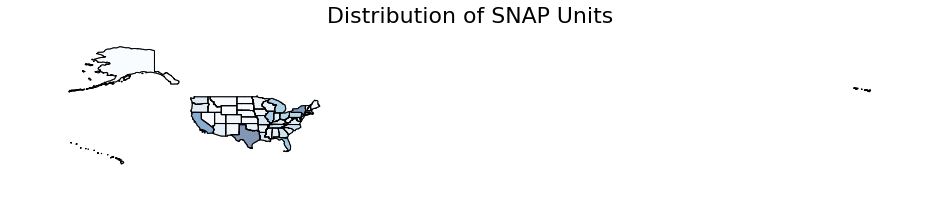

In [8]:
#Create plotting object
fig,ax=plt.subplots(figsize=(16,14))

#Plot uninsured population by state
map_dict[2006].plot(column='FYWGT',axes=ax,colormap='Blues')

#Get rid of chart junk (axes)
ax.set_axis_off()

#Set title
ax.set_title('Distribution of SNAP Units',fontsize=22)

#Set aspect ratio
ax.set_aspect(1);

Super unhelpful right?  That little guy all the way to the east is actually part of Alaska wrapping around.  In any event, this is why we need to separate out the continental US.  If only we could plot Hawaii and Alaska in close proximity to our main plot of the continental US.  Fortunately, **matplotlib** provides the capacity for some custom plotting.

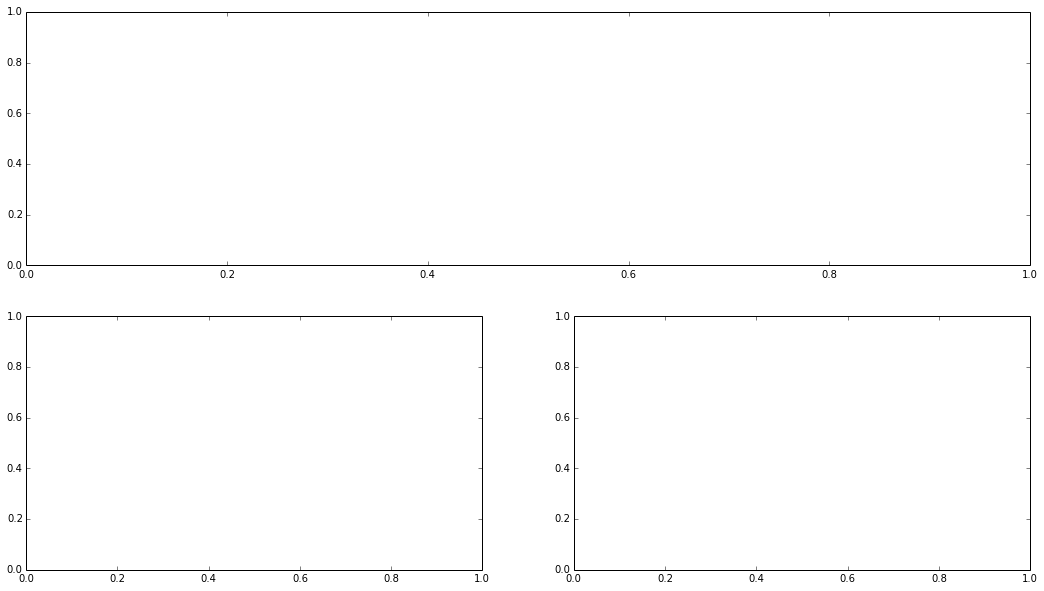

In [ ]:
#Generate plotting figure
fig=plt.figure(figsize=(18,10))

#Generate new axes in custom locations
ax1=plt.subplot2grid((2,2),(0,0),colspan=2)
ax2=plt.subplot2grid((2,2),(1,0),colspan=1)
ax3=plt.subplot2grid((2,2),(1,1))

Let's put this all together.

In [ ]:
#Generate plotting figure
fig=plt.figure(figsize=(18,10))

#Generate new axes in custom locations
ax1=plt.subplot2grid((2,2),(0,0),colspan=2)
ax2=plt.subplot2grid((2,2),(1,0),colspan=1)
ax3=plt.subplot2grid((2,2),(1,1))

#Plot uninsured population by state
map_dict[2006].ix[continental].plot(column='FYWGT',axes=ax1,colormap='Blues')
map_dict[2006].ix[['02','15']].plot(column='FYWGT',axes=ax2,colormap='Blues')
# gp.GeoSeries(map_dict[2006].ix['15']['FYWGT']).plot(axes=ax3,colormap='Blues')

#Get rid of chart junk (axes)
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

#Set title
ax1.set_title('Distribution of SNAP Units',fontsize=22)

#Set aspect ratio
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1);

You may notice that Michigan looks a bit jacked up.  This is actually a function of the underlying shapefile.  A higher resolution file would not have this issue.

Unfortunately, GeoPandas does not appear to offer a clean method of plotting a single feature.  In a nutshell, once a particular feature has been isolated, it is no longer a **[`GeoSeries`](http://geopandas.org/user.html#geoseries)**.  Consequently, **`GeoSeries`** methods (like `plot()`) are not available.  The upshot is that while GeoPandas is an excellent way to generate quick and dirty plots, when more control is needed, a lower-level solution is required.

## Low-Level Mapping with **matplotlib**

To get into the weeds, we will need a few more tools.

In [ ]:
#Spatial I/O
import fiona

#Geometric operations
from shapely.geometry import shape,Polygon,MultiPolygon
from shapely.ops import unary_union

#Geometric plotting
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

#Color
from mpltools import color

### Data Input

Instead of reading in with GeoPandas, we will need to work with a different sort of object.  We can pull in a [dict](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) mapping of the features with **[fiona](http://toblerity.org/fiona/manual.html)**.

In [ ]:
#Open state shapefile
# st_shp=fiona.open(shp_dir+'tl_2013_us_state.shp')
st_shp=fiona.open(shp_dir+'states.shp')

#Initiate iterator to read records
st=st_shp.next()

#Create container for features, FIPS codes, and names
st_list=[]
st_fips_list=[]
st_name_list=[]

#For each feature (state)...
for st in st_shp:
    #...throw the feature in the list...
    st_list.append(shape(st['geometry']))
    #...the associated FIPS code....
#     st_fips_list.append(st['properties']['STATEFP'])
#     #...and the associated name in the other list
#     st_name_list.append(st['properties']['STUSPS'])
    st_fips_list.append(st['properties']['STATE_FIPS'])
    #...and the associated name in the other list
    st_name_list.append(st['properties']['STATE_ABBR'])
    
st

In [102]:
print 'THERE ARE',len(st_list),'STATES AND TERRITORIES IN THE SHAPEFILE'

THERE ARE 51 STATES AND TERRITORIES IN THE SHAPEFILE


In [103]:
print 'SHAPEFILE META INFORMATION'
st_shp.meta

SHAPEFILE META INFORMATION


{'crs': {u'datum': u'NAD83', u'no_defs': True, u'proj': u'longlat'},
 'driver': u'ESRI Shapefile',
 'schema': {'geometry': 'Polygon',
  'properties': OrderedDict([(u'STATE_NAME', 'str:25'), (u'DRAWSEQ', 'int:2'), (u'STATE_FIPS', 'str:2'), (u'SUB_REGION', 'str:20'), (u'STATE_ABBR', 'str:2')])}}

### Inspection

When mapping states, it's important that we are dealing with simple **`Polygon`** objects.  The reason is that **`MultiPolygons`** are [iterable](http://www.shutupandship.com/2012/01/understanding-python-iterables-and.html), and therefore behave differently/are incompatible with certain operations.  (As the name suggests, **`MultiPolygons`** are just groups of **`Polygons`**.)  Thus, upfront validation is a good idea.

In [104]:
#Generate dict mapping FIPS to features
st_dict=dict(zip(st_fips_list,st_list))

#Generate dict mapping FIPS to names
st_nm_dict=dict(zip(st_fips_list,st_name_list))

#Capture non-Polygon objects
nonpoly=sorted([x[0] for x in st_dict.items() if x[1].geom_type != 'Polygon'])
print 'FEATURES THAT ARE NOT POLYGONS:',nonpoly
print 'ASSOCIATED NON-POLYGON NAMES:,',[st_nm_dict[st] for st in nonpoly]

FEATURES THAT ARE NOT POLYGONS: [u'02', u'06', u'12', u'13', u'15', u'21', u'22', u'23', u'24', u'25', u'26', u'36', u'37', u'44', u'45', u'48', u'51', u'53', u'55']
ASSOCIATED NON-POLYGON NAMES:, [u'AK', u'CA', u'FL', u'GA', u'HI', u'KY', u'LA', u'ME', u'MD', u'MA', u'MI', u'NY', u'NC', u'RI', u'SC', u'TX', u'VA', u'WA', u'WI']


It's a good thing we checked.  The last four (those with codes `>= 60`) we do not care about because they are not states.  The others, however, must be unpacked so that we apply the same color to every piece of the state.  We can account for these with a conditional loop embedded in the mapping routine.  In other words, as each state is plotted, we will first ask if the state contains multiple pieces.  If so, we will loop through the pieces in monochromatic fashion, before moving on to the next state.

### Color

Obviously color is pretty important in a [choropleth map](http://en.wikipedia.org/wiki/Choropleth_map).  Whereas GeoPandas does the work of assigning colors for us in the quick and dirty plots, we must now assign them explicitly.  That means we need to make choices about the correspondence between colors and values.  Unless there is a compelling case not too, it is generally best to start with a linear colormap.  That is, we will define a range of colors that varies with equivalent increments across the value range for the variable in question.  At any point in the value distribution, a single increment in value will correspond with the same incremental change in color.  To provide for an easy way to embed this mapping in the plotting routine, we will define these mappings as a separate dict for each concept:

1. Number of SNAP Units (`unit_colmap`)
2. Number of SNAP Participants (`part_colmap`)
3. Volume of SNAP Benefits (`ben_colmap`)

In [143]:
#Define function that returns color mappings for states
def colmap(df,var,idvar,colormap,start_col=.2):
    '''Function reads in a variable and determines the colors corresponding to each
    float value in the distribution.  It returns a dict mapping the color to each
    corresponding idvar.  Note that the id variable must be in the index for this
    to function properly.'''
    #Define min and max parameter values
    minval=df[var].min()
    maxval=df[var].max()
    #Generate color mapper
    colmap=color.color_mapper((minval,maxval),cmap=colormap,start=start_col)
    #Generate containers for id values and colors
    id_list=[]
    col_list=[]
    #For each feature...
    for idval in df.index:
        #...throw idval in the list...
        id_list.append(idval)
        #...and the corresponding color in the other list
        col_list.append(colmap(df.ix[idval][var]))
    #Create mapping between idval and colors
    col_dict=dict(zip(id_list,col_list))
    return col_dict

#Create containers for color maps
unit_colmap={}
part_colmap={}
ben_colmap={}
avg_ben_colmap={}

#For each year...
for yr in range(2006,2010):
    #...define colormaps
    unit_colmap.update({yr:colmap(map_dict[yr],'FYWGT','STATEFP','Blues')})
    part_colmap.update({yr:colmap(map_dict[yr],'WPART','STATEFP','Reds')})
    ben_colmap.update({yr:colmap(map_dict[yr],'WBEN','STATEFP','Greens')})
    avg_ben_colmap.update({yr:colmap(map_dict[yr],'AVG_BEN','STATEFP','Greens')})

#Peek at what has been produced
ben_colmap[2006]

{u'01': (0.64364477325888236, 0.85614764409906718, 0.61979241020539222, 1.0),
 u'02': (0.81268743907704077, 0.92664360298829918, 0.78738947826273298, 1.0),
 u'04': (0.63429452391231766, 0.85221069700577678, 0.61068822005215817, 1.0),
 u'05': (0.70909651868483603, 0.88370627375210031, 0.68352174127803134, 1.0),
 u'06': (0.0, 0.39277201715637655, 0.15816993850703331, 1.0),
 u'08': (0.73714726672453035, 0.89551711503197162, 0.7108343117377337, 1.0),
 u'09': (0.76519801476422478, 0.90732795631184293, 0.73814688219743618, 1.0),
 u'10': (0.81637832697700052, 0.92811995814828308, 0.79132642535602349, 1.0),
 u'11': (0.80899655117708091, 0.92516724782831528, 0.78345253116944258, 1.0),
 u'12': (0.33254902958869936, 0.70865053639692421, 0.40276817188543435, 1.0),
 u'13': (0.44549019932746886, 0.76401385489632101, 0.45813149038483114, 1.0),
 u'15': (0.7942329995772418, 0.91926182718837968, 0.76770474279628087, 1.0),
 u'16': (0.80899655117708091, 0.92516724782831528, 0.78345253116944258, 1.0),
 u'1

### Plotting

We are now ready to plot our data.  The first thing we need to do is determine our plot scope.  As we saw above, we actually want to capture three different plot scopes:

1.  Continental US
2.  Alaska
3.  Hawaii

Consequently, we need to capture only the relevant states when establishing said scope.  We can leverage our continental subset we created when going the GeoPandas route.

In [145]:
#Establish scopes
cus_scope=unary_union([st_dict[fips] for fips in continental]).bounds
ak_scope=unary_union(st_dict['02']).bounds
hi_scope=unary_union(st_dict['15']).bounds

With our scopes in hand, we can define a function to plot the data.  Let's test the continental US...

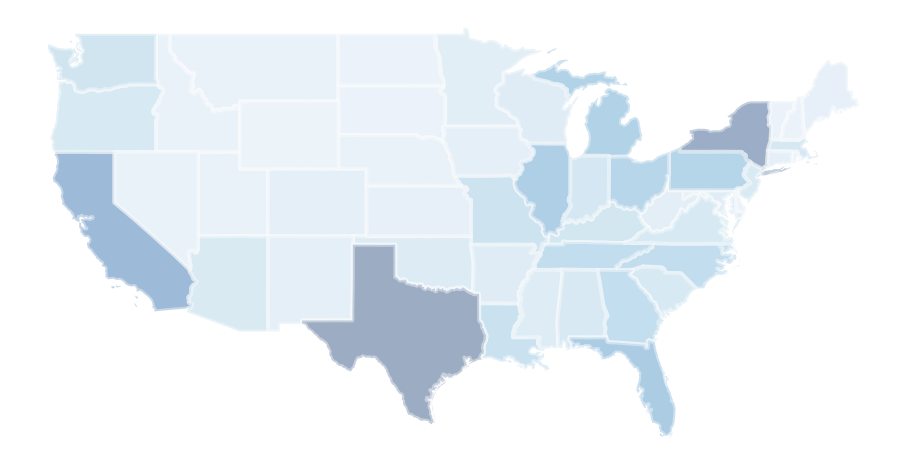

In [156]:
#Generate plot object
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)

def col_plot(desired_states,scope,var_colors,ax=ax):
    #Restrict to relevant states in scope
    st_subset=[item for item in st_dict.items() if item[0] in desired_states]
    
    #Set scope of plot (manually cut off eastern extent of Alaska)
    minx, miny, maxx, maxy = scope
    if desired_states==['02']:
        maxx=-130.
    w, h = maxx - minx, maxy - miny
    ax.set_xlim(minx - 0.05 * w, maxx + 0.05 * w)
    ax.set_ylim(miny - 0.05 * h, maxy + 0.05 * h)
    
    #Set aspect ratio
    ax.set_aspect(1.2)
    
    #Create container for patches (neighborhoods in this context), locations, and names
    patches = []
    patch_loc=[]
    patch_nm=[]
    
    #For each state...
    for i,patch in enumerate(st_subset):
        #...assign a color from relevant color mapping...
        col=var_colors[patch[0]]
        #...if the state is represented by a MultiPolygon...
        if patch[1].geom_type != 'Polygon':
            #...generate a patch representing each part of the state and throw it in the list...
            for patch_part in patch[1]:
#                 patches.append(PolygonPatch(patch_part,fc=col,ec='#555555',lw=0.2,alpha=0.4,zorder=1,label=patch[0]))
                patches.append(PolygonPatch(patch_part,fc=col,ec='w',lw=4,alpha=0.4,zorder=1,label=patch[0]))
        else:
            #...otherwise generate a patch representing the entire state and throw it in the list...
#             patches.append(PolygonPatch(patch[1],fc=col,ec='#555555',lw=0.2,alpha=0.4,zorder=1,label=patch[0]))
            patches.append(PolygonPatch(patch[1],fc=col,ec='w',lw=4,alpha=0.4,zorder=1,label=patch[0]))
        #...and capture the patch location and name
        patch_loc.append((patch[1].centroid.x-.3,patch[1].centroid.y))
        patch_nm.append(st_nm_dict[patch[0]])
        
    #Add the patches to the plot object en masse
    ax.add_collection(PatchCollection(patches, match_original=True))
    
    #Add labels
#     for i,loc in enumerate(patch_loc):
#         ax.annotate(patch_nm[i],xy=loc,size=8)
        
    #Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');
    
col_plot(continental,cus_scope,unit_colmap[2006],ax=ax)

Now let's try to capture all 50 states at once.  Note that this time, we would like to provide the proper context for color by including a colorbar in the plot.  How might we execute this bit of (as it turns out) frustratingly subtle finesse?  We will leverage [GridSpec](http://matplotlib.org/users/gridspec.html), the layout tool used in the GeoPandas section.  Rather, it will be the same basic infrastructure, but the implementation will be slightly different to afford us lower level control.  GridSpec allows us to place and size subplots via a grid coordinate structure.  The feature that will unlock use of the colorbar is the ability manage multiple clusters in the same horizontal space.  We can use said feature to create a "floating" axis for the colorbar, which we can fill based upon the desired colormap and parameter space.  This is the reason that the function below will take some redundant information (that which was used in the original color mapping above) as parametric inputs.

And...

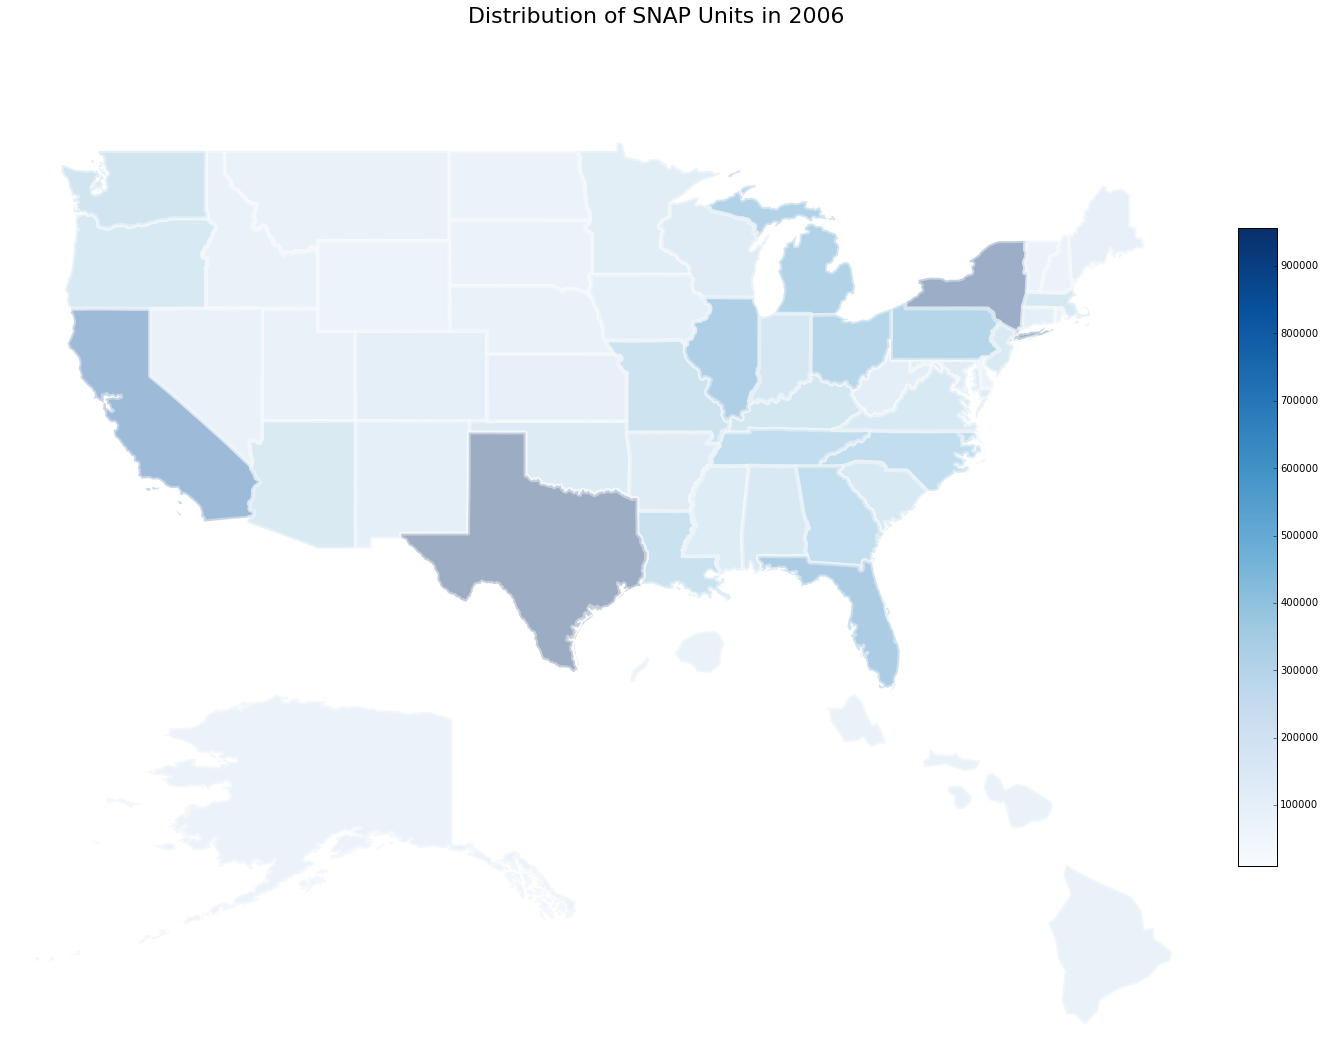

In [157]:
#Define function to plot relevant variable
def snap_plot(df,var,colormap,cmap_cycle):
    #Generate plotting figure
    fig=plt.figure(figsize=(18,20))

    #Generate new axes in custom locations
    gs1=matplotlib.gridspec.GridSpec(2,2)
    gs1.update(left=0.0, right=0.92, wspace=0.0,top=.98)
    ax1=plt.subplot(gs1[0,:])
    ax2=plt.subplot(gs1[1,0])
    ax3=plt.subplot(gs1[1,1])
    
    #Generate floating axis for colorbar
    gs2=matplotlib.gridspec.GridSpec(20,1)
    gs2.update(left=0.95, right=0.98)
    ax4=plt.subplot(gs2[2:13,0])
    
    #Plot number of SNAP units by state
    col_plot(continental,cus_scope,colormap,ax=ax1)
    col_plot(['02'],ak_scope,colormap,ax=ax2)
    col_plot(['15'],hi_scope,colormap,ax=ax3)
    
    #Adjust spacing of subplots
    plt.subplots_adjust(hspace=-.5)
    
    #Fill in colorbar
    norm=matplotlib.colors.Normalize(vmin=df[var].min(),vmax=df[var].max())
    matplotlib.colorbar.ColorbarBase(ax=ax4,cmap=cmap_cycle,norm=norm)
    
#Plot 2006 SNAP units
snap_plot(map_dict[2006],'FYWGT',unit_colmap[2006],'Blues')
    
#Add title
plt.suptitle('Distribution of SNAP Units in 2006',fontsize=22);

Well that seems to have worked out just fine, and now we have a high-level function that will do the leg work for us.  Note that the labels could be placed explicitly for publication quality work.  At the current time, they all sit approximately at the centroid of the state (which obviously creates noticeable problems in the presence of [concavity](http://en.wikipedia.org/wiki/Convex_and_concave_polygons)).

## Distribution of SNAP Activity

### SNAP Units

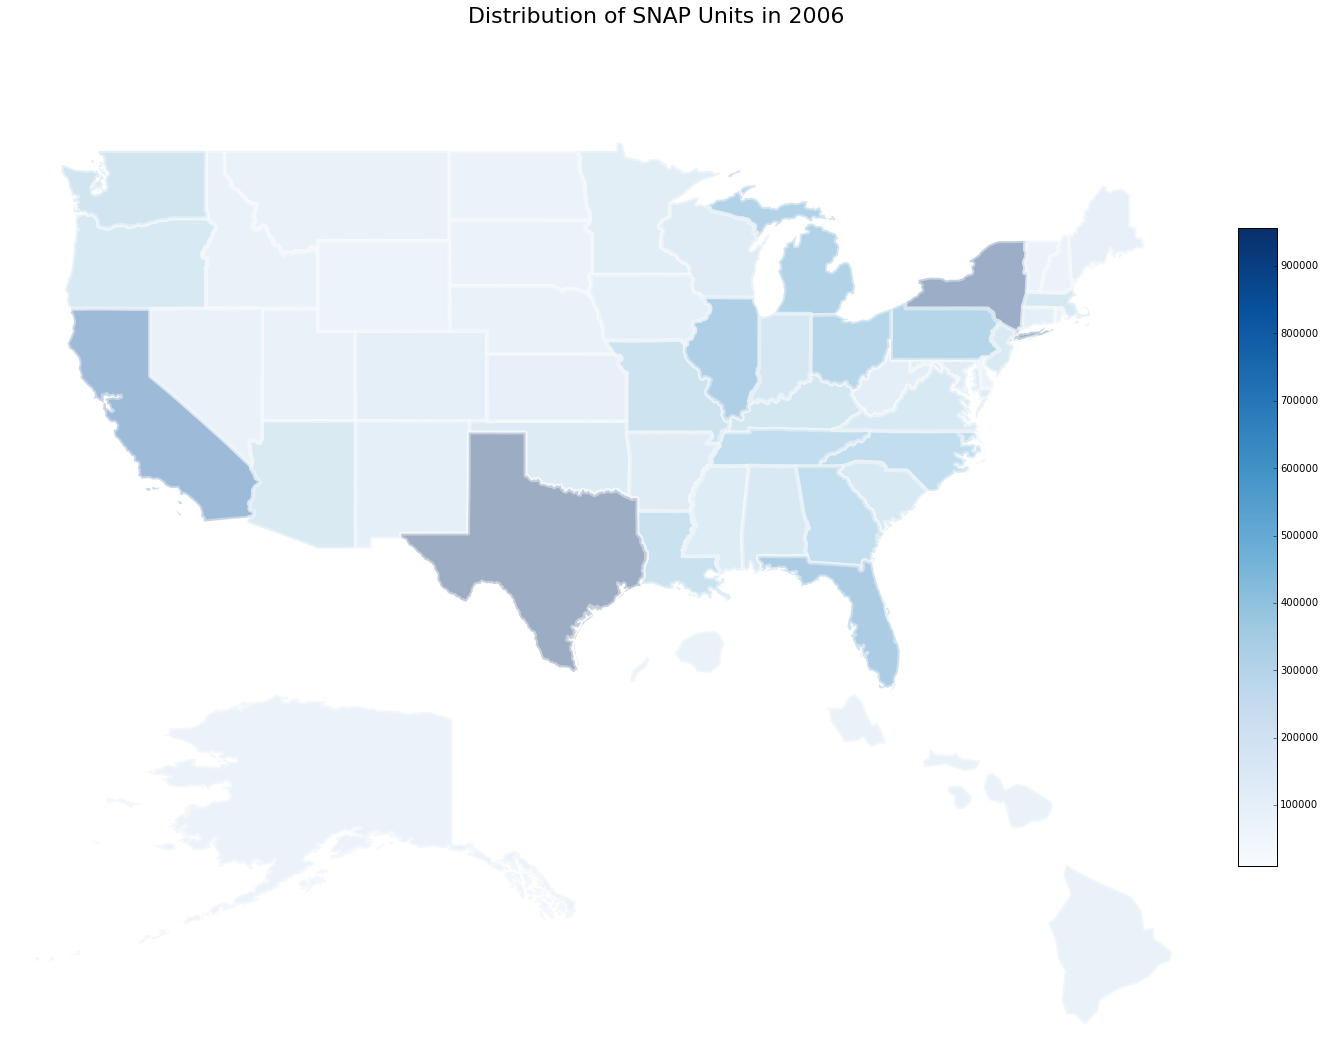

In [158]:
#Plot 2006 SNAP units
snap_plot(map_dict[2006],'FYWGT',unit_colmap[2006],'Blues')
    
#Add title
plt.suptitle('Distribution of SNAP Units in 2006',fontsize=22)

plt.savefig('SNAP_units_abs_dist2006.png',dpi=500)

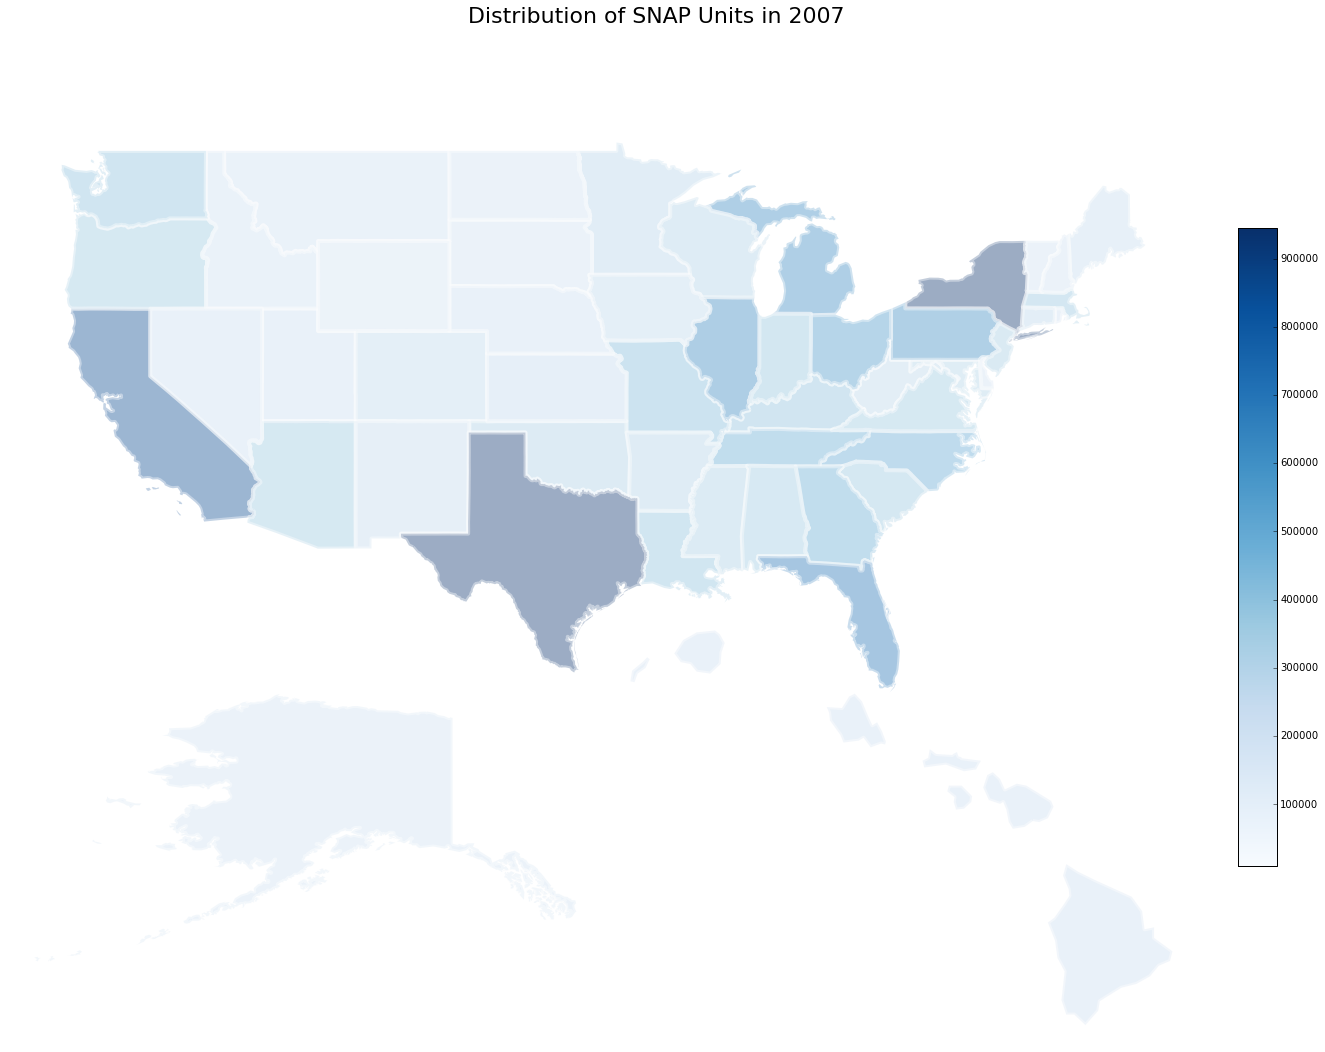

In [159]:
#Plot 2007 SNAP units
snap_plot(map_dict[2007],'FYWGT',unit_colmap[2007],'Blues')
    
#Add title
plt.suptitle('Distribution of SNAP Units in 2007',fontsize=22)

plt.savefig('SNAP_units_abs_dist2007.png',dpi=500)

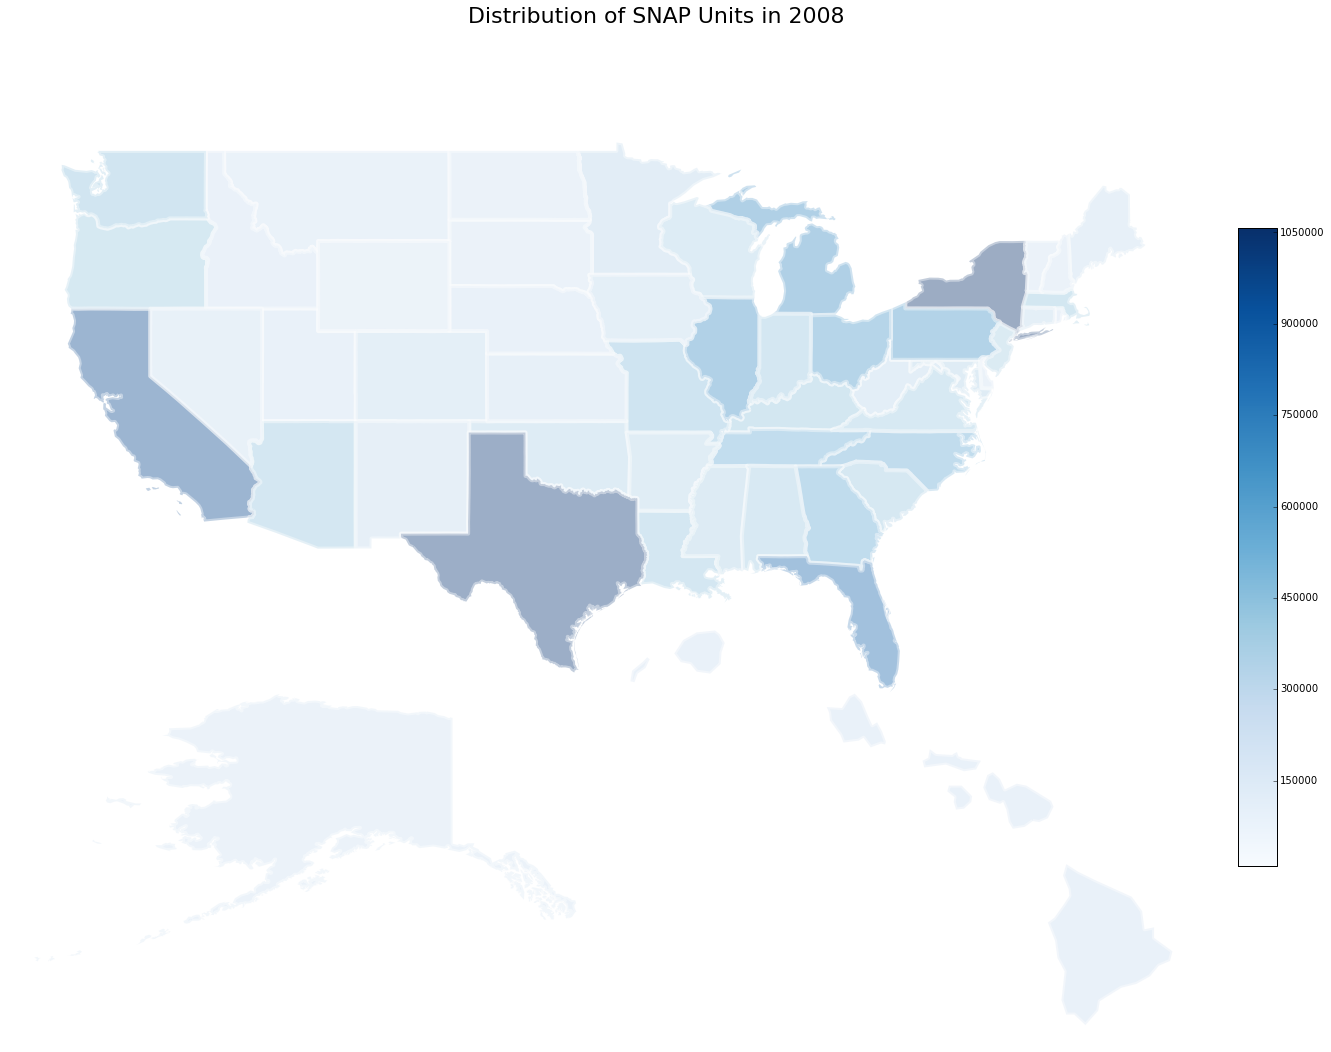

In [160]:
#Plot 2008 SNAP units
snap_plot(map_dict[2008],'FYWGT',unit_colmap[2008],'Blues')
    
#Add title
plt.suptitle('Distribution of SNAP Units in 2008',fontsize=22)

plt.savefig('SNAP_units_abs_dist2008.png',dpi=500)

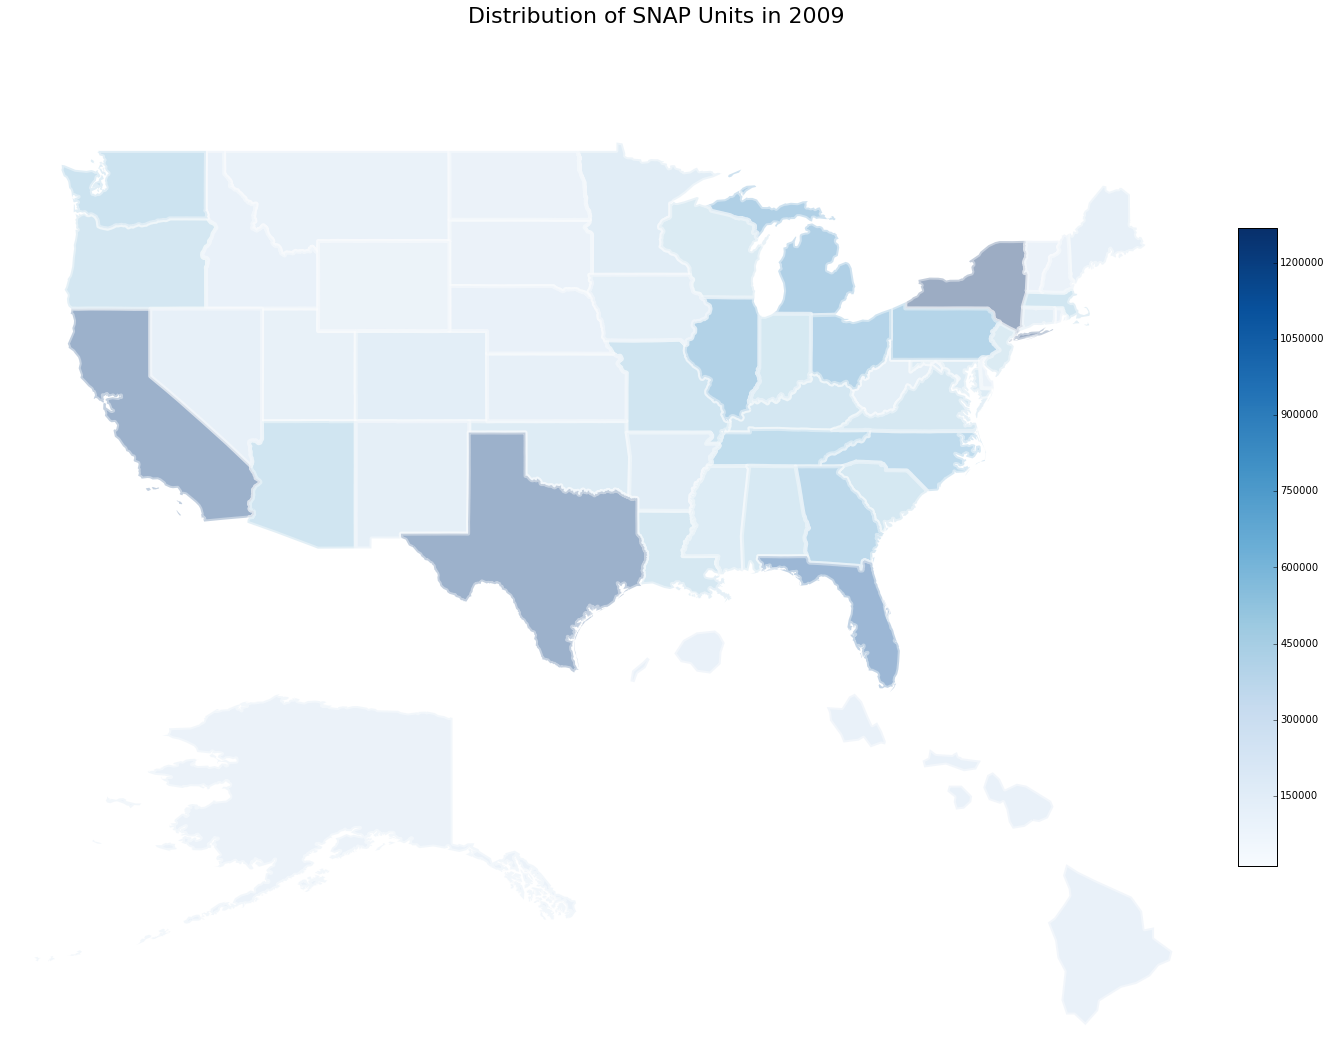

In [161]:
#Plot 2009 SNAP units
snap_plot(map_dict[2009],'FYWGT',unit_colmap[2009],'Blues')
    
#Add title
plt.suptitle('Distribution of SNAP Units in 2009',fontsize=22)

plt.savefig('SNAP_units_abs_dist2009.png',dpi=500)

### SNAP Participants

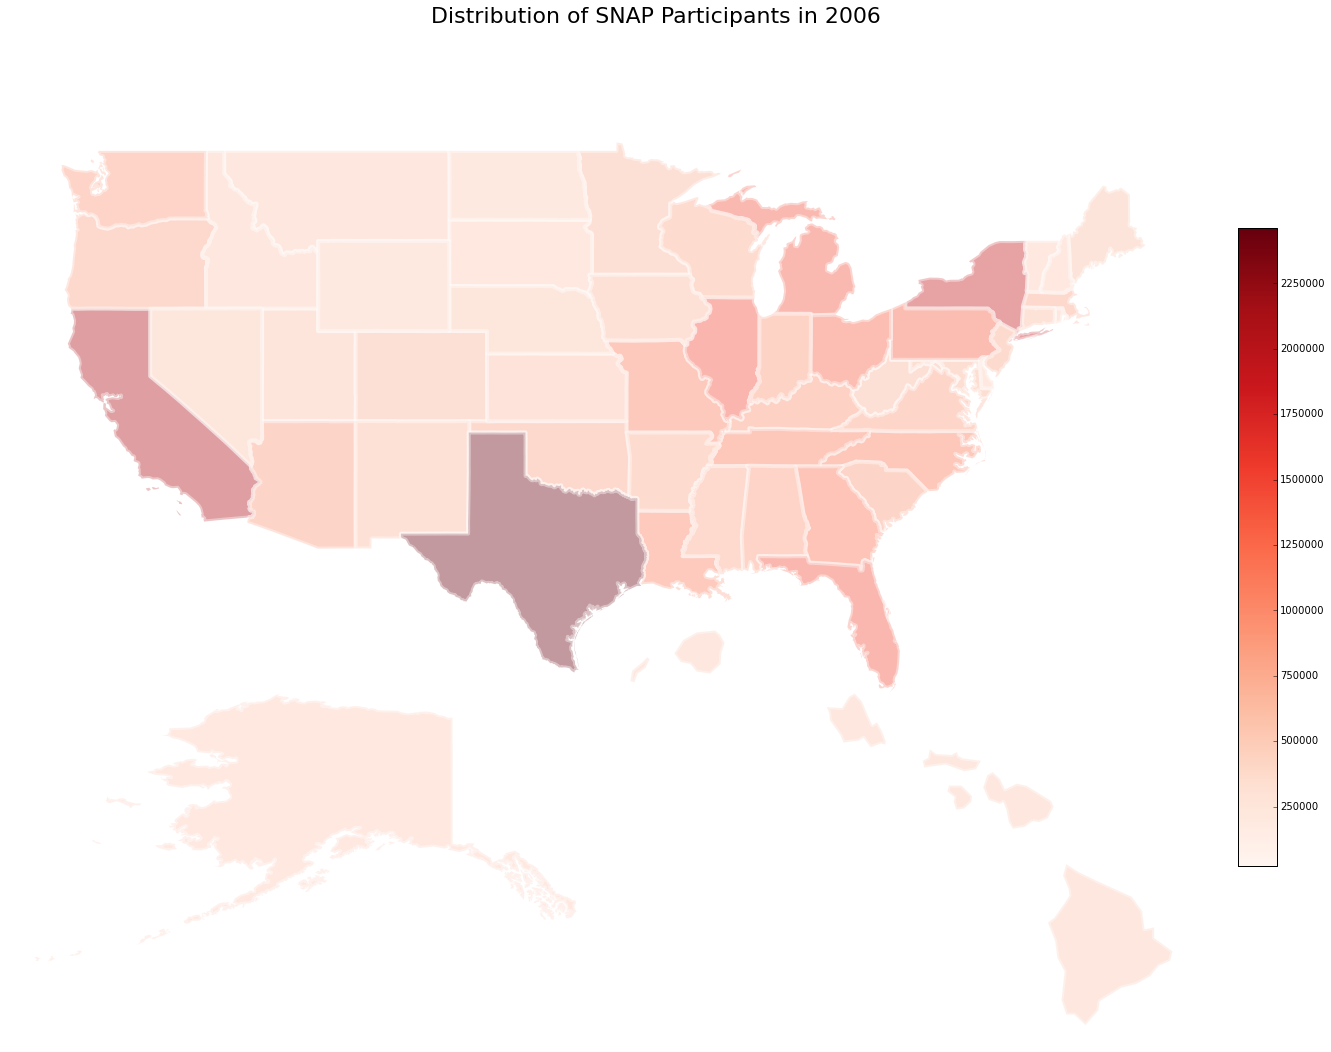

In [162]:
#Plot 2006 SNAP participants
snap_plot(map_dict[2006],'WPART',part_colmap[2006],'Reds')
    
#Add title
plt.suptitle('Distribution of SNAP Participants in 2006',fontsize=22)

plt.savefig('SNAP_participants_abs_dist2006.png',dpi=500)

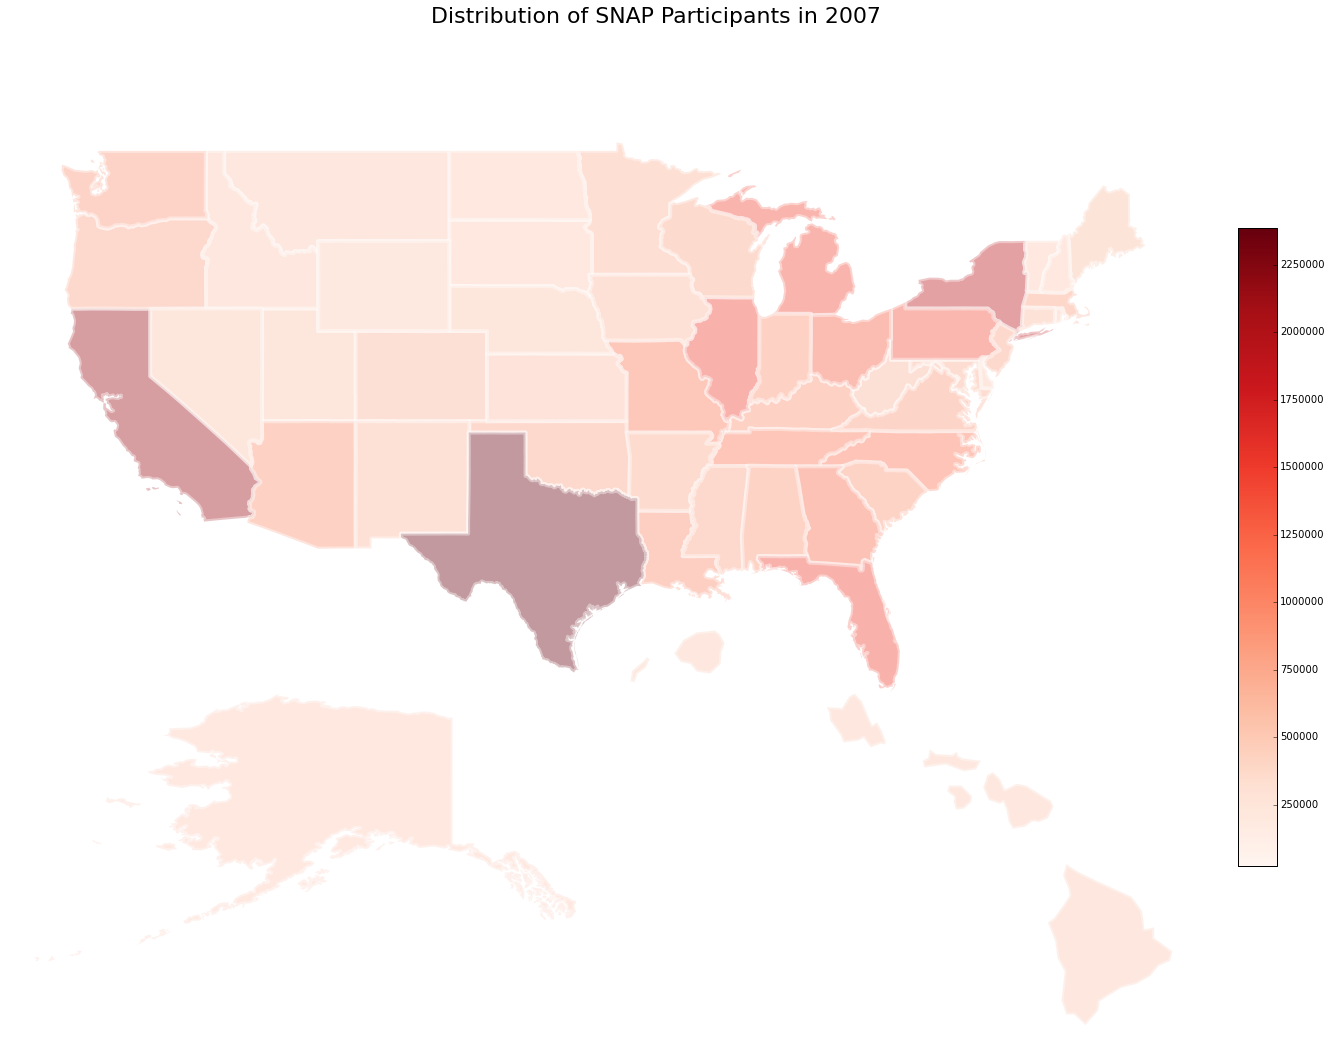

In [163]:
#Plot 2007 SNAP participants
snap_plot(map_dict[2007],'WPART',part_colmap[2007],'Reds')
    
#Add title
plt.suptitle('Distribution of SNAP Participants in 2007',fontsize=22)

plt.savefig('SNAP_participants_abs_dist2007.png',dpi=500)

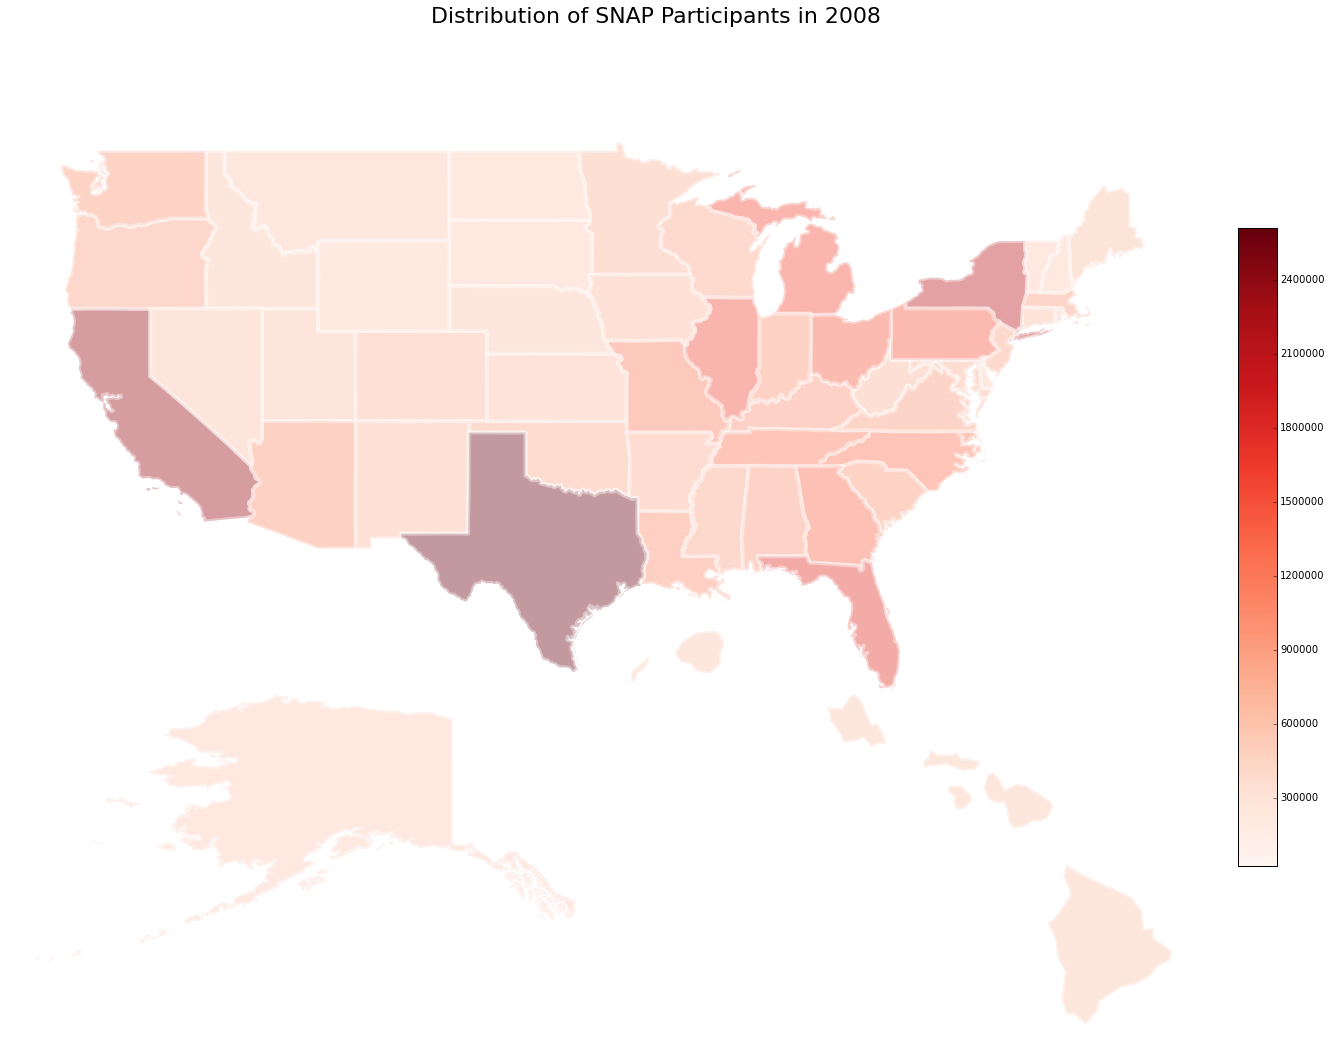

In [164]:
#Plot 2008 SNAP participants
snap_plot(map_dict[2008],'WPART',part_colmap[2008],'Reds')
    
#Add title
plt.suptitle('Distribution of SNAP Participants in 2008',fontsize=22)

plt.savefig('SNAP_participants_abs_dist2008.png',dpi=500)

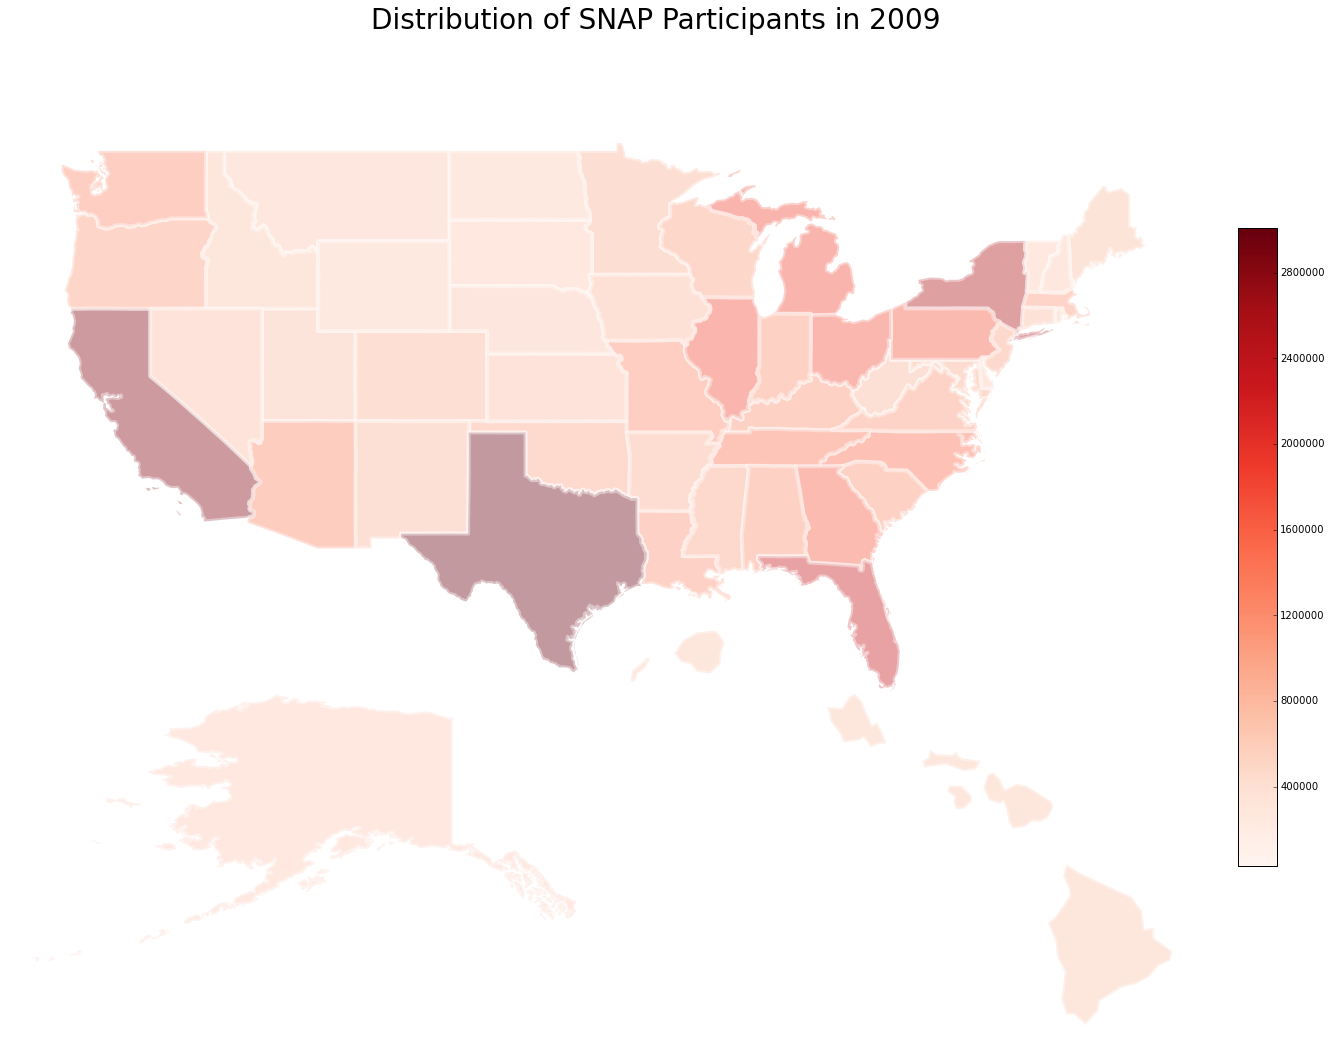

In [176]:
#Plot 2009 SNAP participants
snap_plot(map_dict[2009],'WPART',part_colmap[2009],'Reds')
    
#Add title
plt.suptitle('Distribution of SNAP Participants in 2009',fontsize=28)

plt.savefig('SNAP_participants_abs_dist2009.png',dpi=500,bbox_inches='tight')
plt.savefig('./SNAP_Pres_Data/SNAP_participants_abs_dist2009.svg',bbox_inches='tight')

In [166]:
print map_dict[2009][['NAME','WPART']][map_dict[2009]['WPART']==map_dict[2009]['WPART'].max()]
print map_dict[2009][['NAME','WPART']][map_dict[2009]['WPART']==map_dict[2009]['WPART'].min()]

          NAME         WPART
STATEFP                     
48       Texas  3007274.5915
            NAME         WPART
STATEFP                       
56       Wyoming  28384.517293


In [174]:
map_dict[2009][['NAME','WPART','AVG_BEN']].to_csv('./SNAP_Pres_Data/SNAP_by_State2009.csv')

### SNAP Benefit Volumes

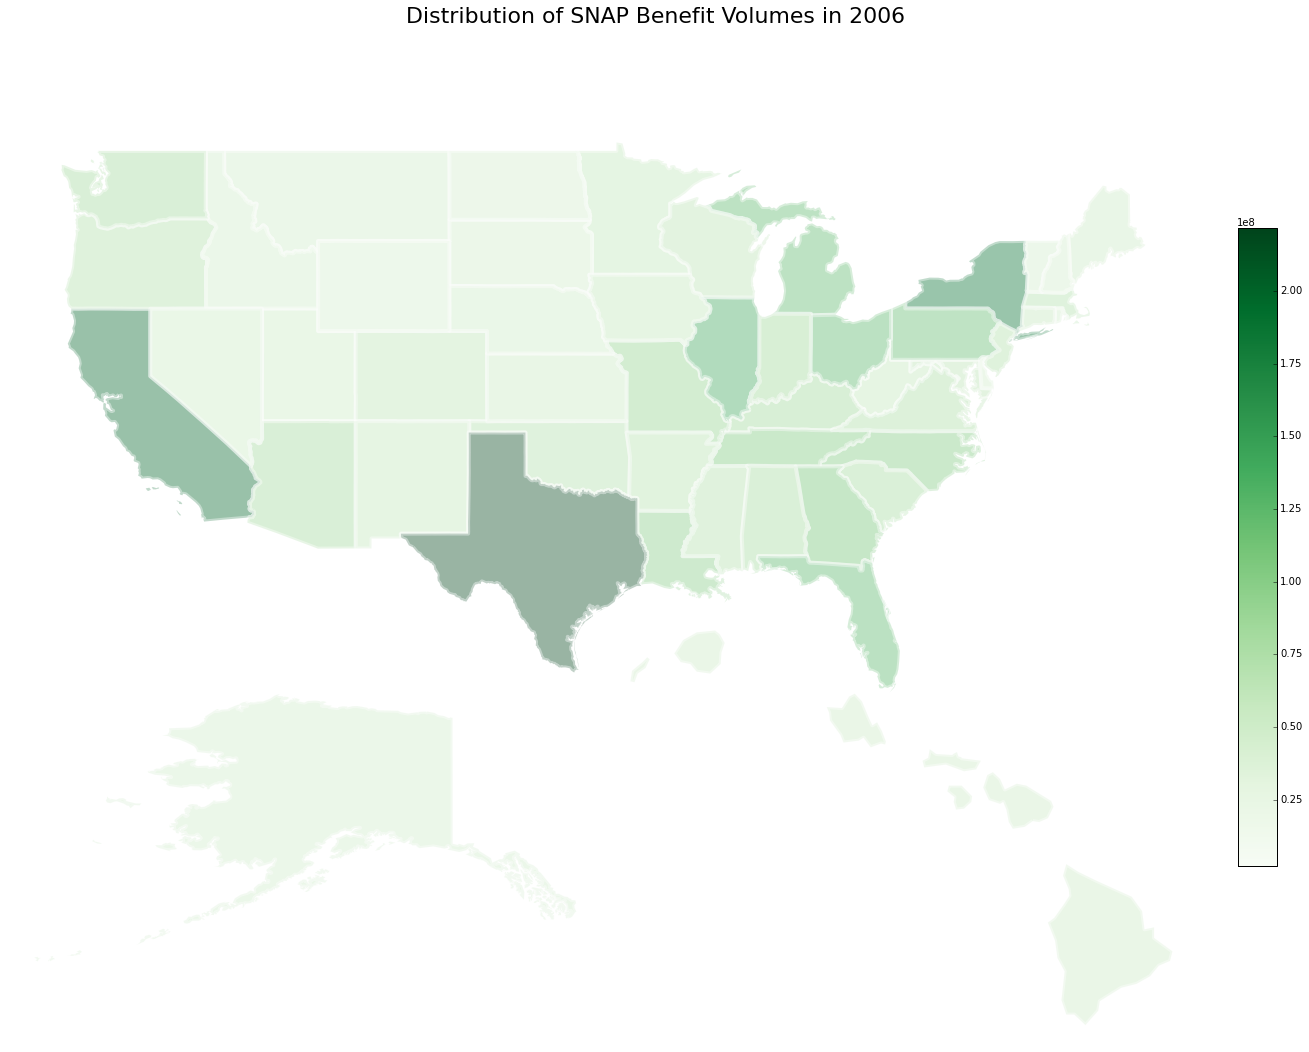

In [167]:
#Plot 2006 SNAP benefit volumes
snap_plot(map_dict[2006],'WBEN',ben_colmap[2006],'Greens')
    
#Add title
plt.suptitle('Distribution of SNAP Benefit Volumes in 2006',fontsize=22)

plt.savefig('SNAP_benefits_abs_dist2006.png',dpi=500)

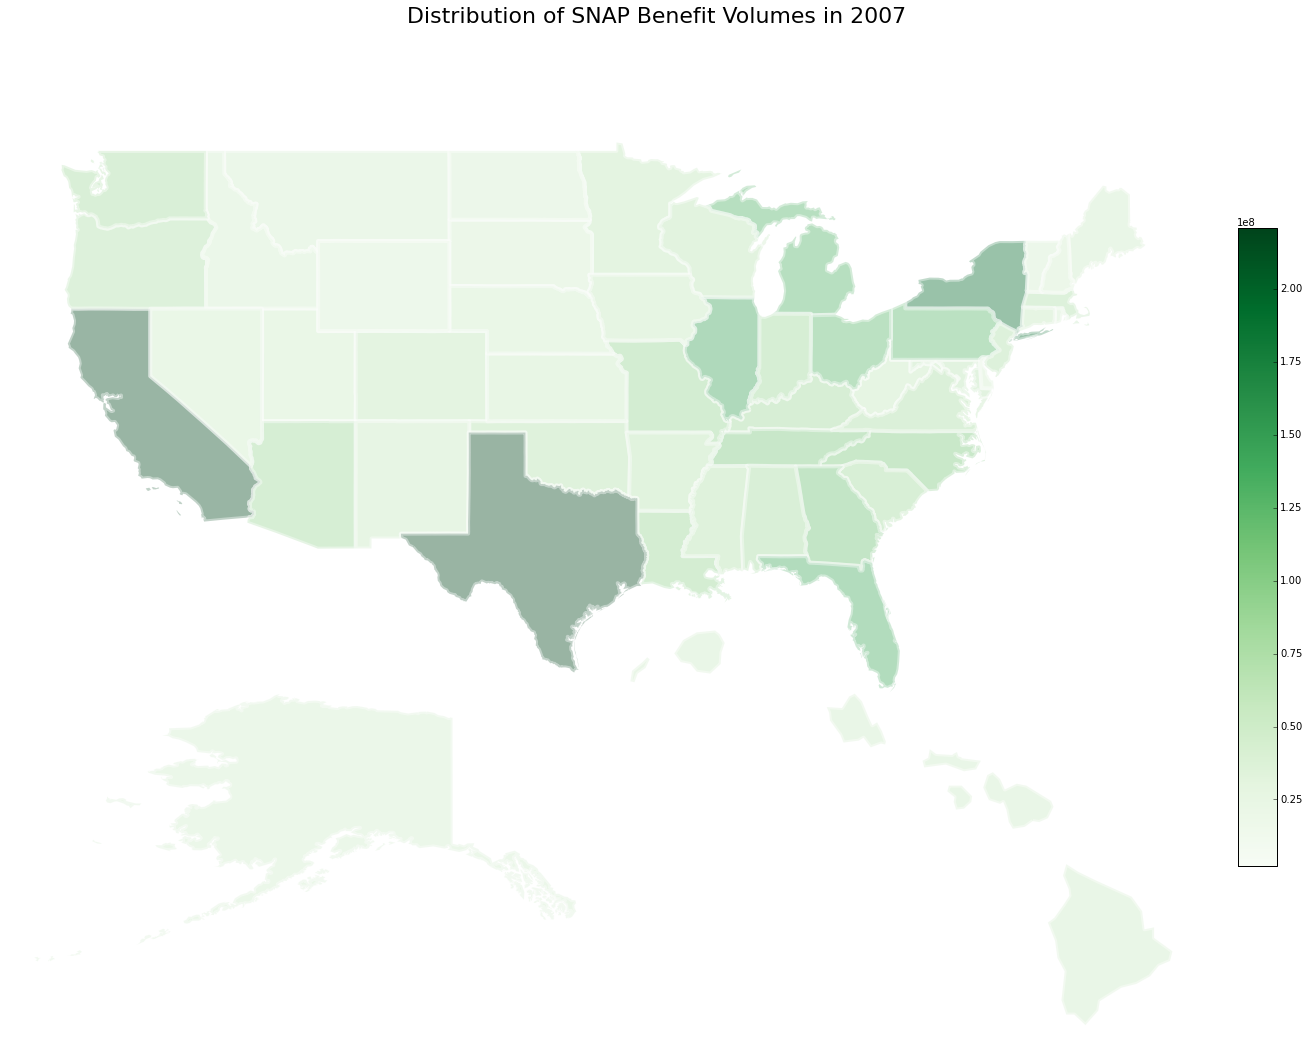

In [168]:
#Plot 2007 SNAP benefit volumes
snap_plot(map_dict[2007],'WBEN',ben_colmap[2007],'Greens')
    
#Add title
plt.suptitle('Distribution of SNAP Benefit Volumes in 2007',fontsize=22)

plt.savefig('SNAP_benefits_abs_dist2007.png',dpi=500)

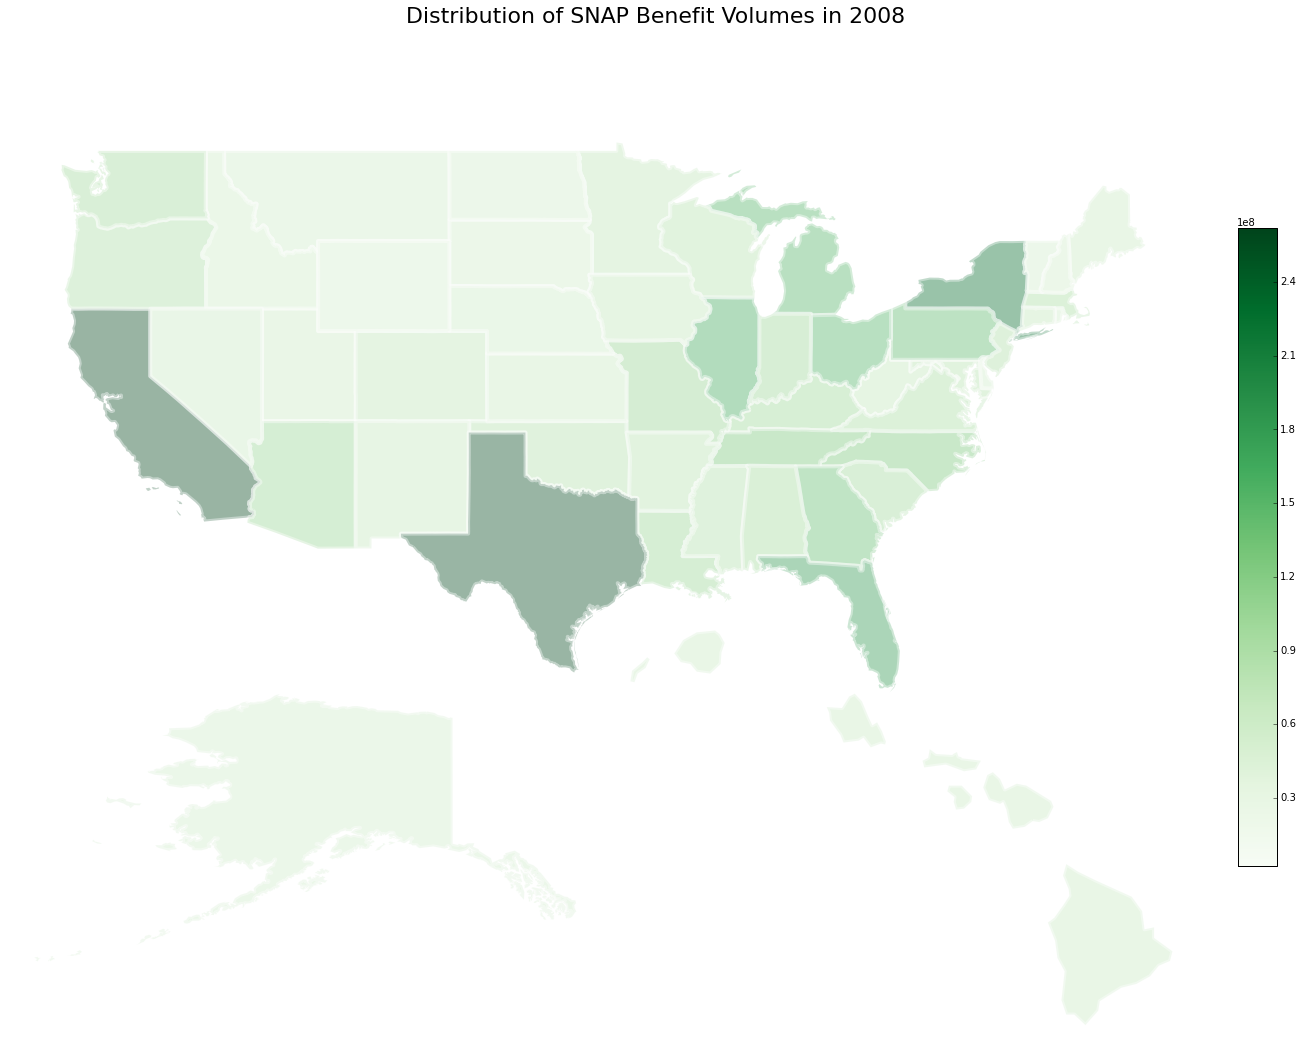

In [169]:
#Plot 2008 SNAP benefit volumes
snap_plot(map_dict[2008],'WBEN',ben_colmap[2008],'Greens')
    
#Add title
plt.suptitle('Distribution of SNAP Benefit Volumes in 2008',fontsize=22)

plt.savefig('SNAP_benefits_abs_dist2008.png',dpi=500)

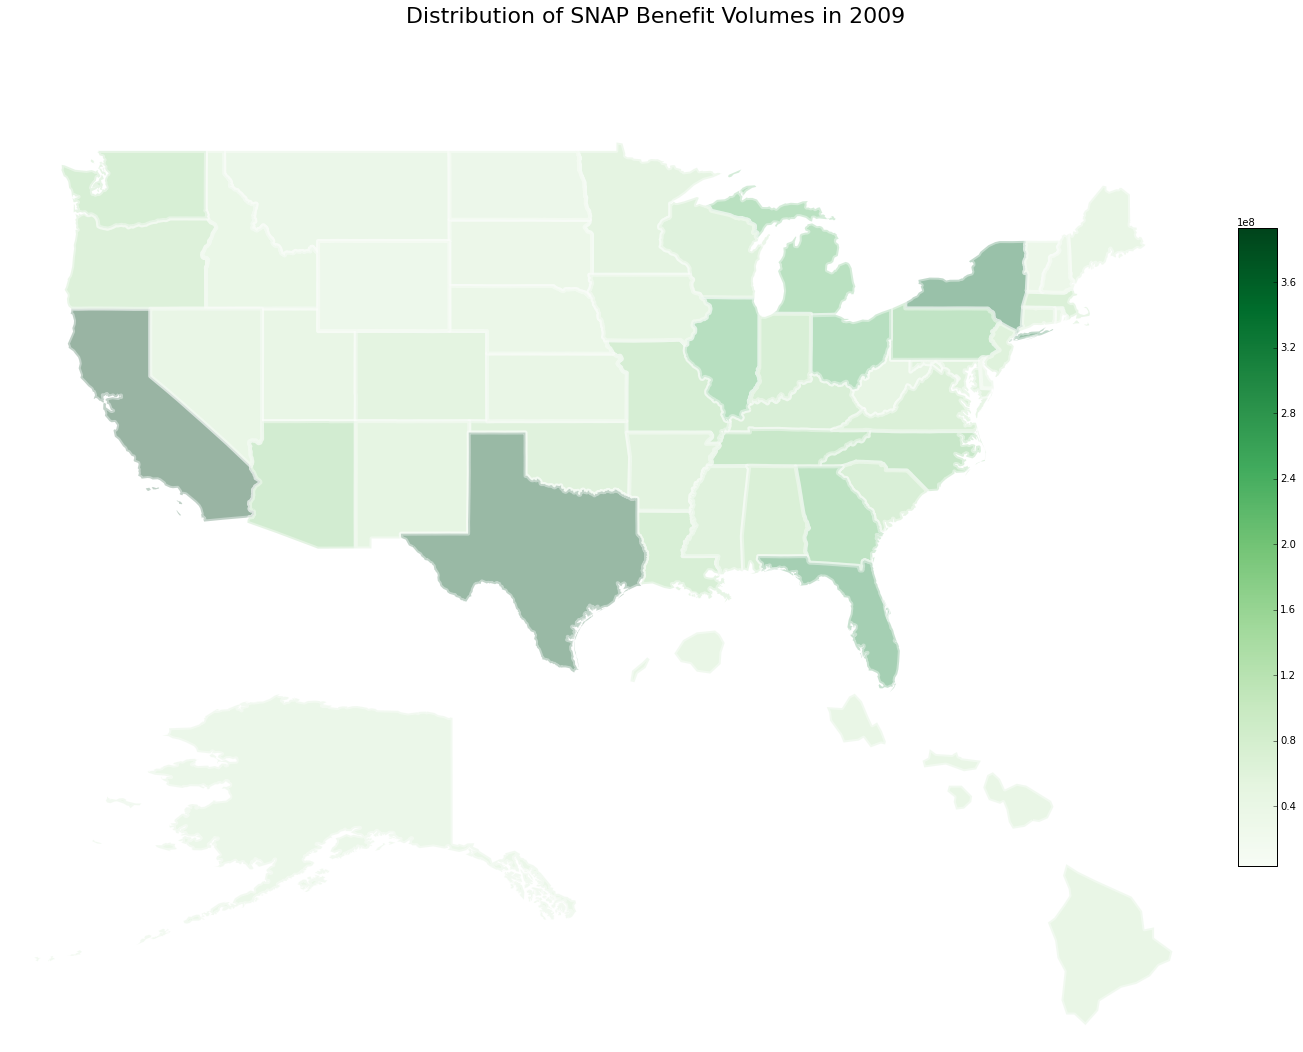

In [170]:
#Plot 2009 SNAP benefit volumes
snap_plot(map_dict[2009],'WBEN',ben_colmap[2009],'Greens')
    
#Add title
plt.suptitle('Distribution of SNAP Benefit Volumes in 2009',fontsize=22)

plt.savefig('SNAP_benefits_abs_dist2009.png',dpi=500)

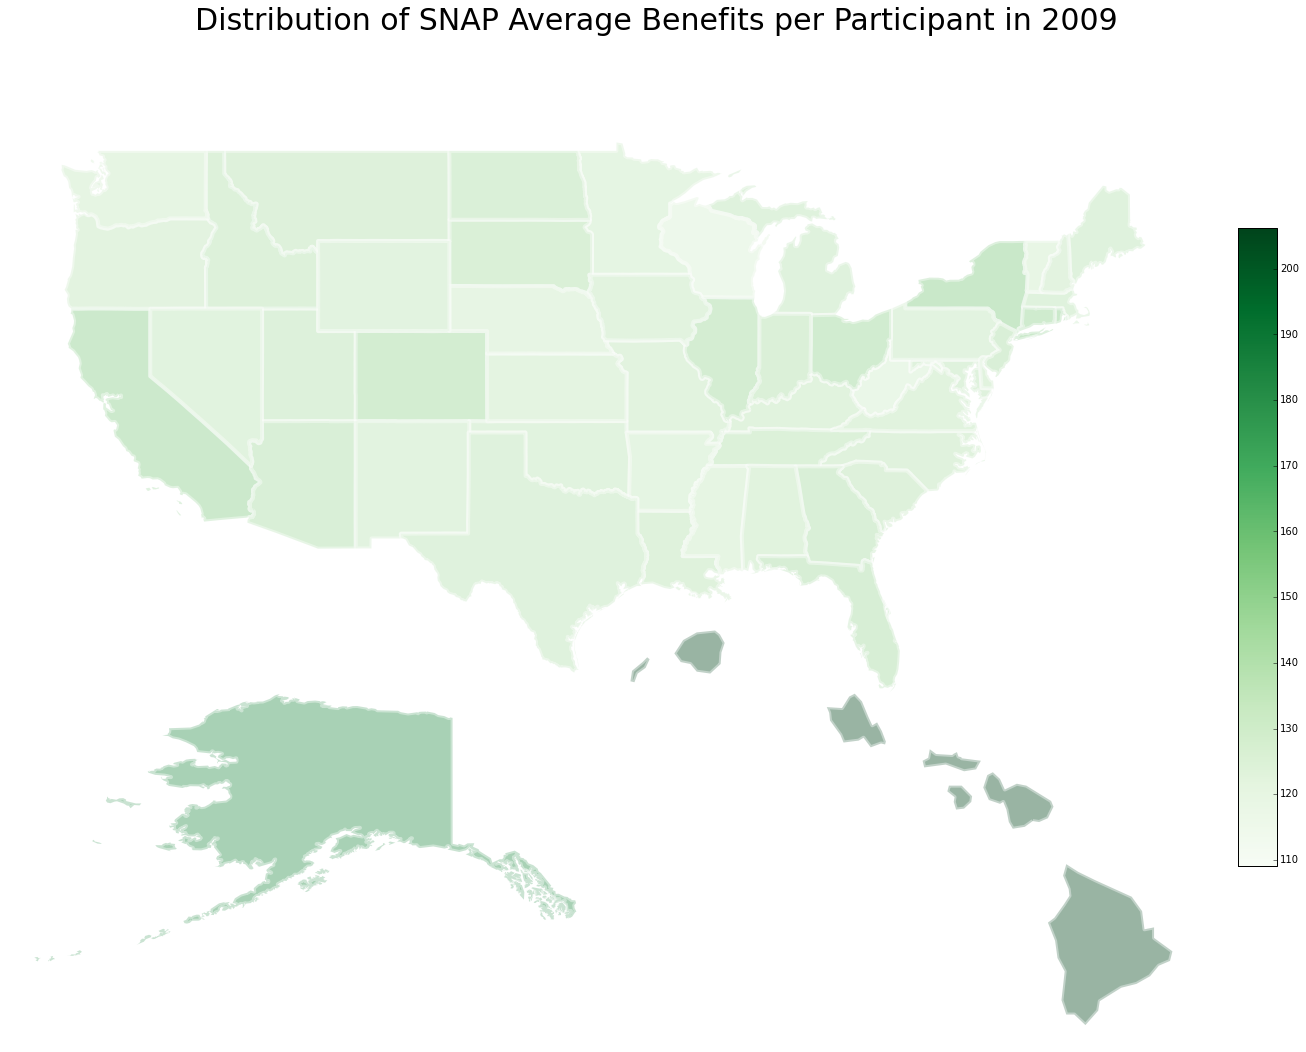

In [171]:
#Plot 2009 SNAP benefit volumes
snap_plot(map_dict[2009],'AVG_BEN',avg_ben_colmap[2009],'Greens')
    
#Add title
plt.suptitle('Distribution of SNAP Average Benefits per Participant in 2009',fontsize=30)

plt.savefig('SNAP_avg_benefits_abs_dist2009.png',dpi=500,bbox_inches='tight')

In [172]:
print map_dict[2009][['NAME','AVG_BEN']][map_dict[2009]['AVG_BEN']==map_dict[2009]['AVG_BEN'].max()]
print map_dict[2009][['NAME','AVG_BEN']][map_dict[2009]['AVG_BEN']==map_dict[2009]['AVG_BEN'].min()]

           NAME     AVG_BEN
STATEFP                    
15       Hawaii  206.116297
              NAME     AVG_BEN
STATEFP                       
55       Wisconsin  109.051903


In [173]:
map_dict[2009]['AVG_BEN'].describe()

count     51.000000
mean     127.873897
std       15.029620
min      109.051903
25%      121.067417
50%      124.126226
75%      130.035534
max      206.116297
Name: AVG_BEN, dtype: float64